In [4]:


%reload_ext autoreload
%autoreload 2
from alpharaw.ms_data_base import ms_reader_provider
from alpharaw import register_all_readers
from dia_aspire_rescore.io import read_diann2
import pandas as pd
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
from dia_aspire_rescore.psm.matcher import DIAPeptideSpectrumMatcher
from alphabase.peptide.fragment import create_fragment_mz_dataframe, flatten_fragments
import logging
# Configure logging: DEBUG for dia_aspire_rescore, WARNING for numba
logging.basicConfig(
    level=logging.WARNING,  # Root logger at WARNING level
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
# Enable DEBUG for dia_aspire_rescore package
logging.getLogger('dia_aspire_rescore').setLevel(logging.DEBUG)
# Disable DEBUG for numba (set to WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)

register_all_readers()


In [5]:
psm_df_original = read_diann2("../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
# decreasing rt order
psm_df_sorted = psm_df_original.sort_values(by="rt", ascending=False)
psm_df_sorted = psm_df_sorted[psm_df_sorted['fdr1_search1'] < 0.01].reset_index(drop=True)
psm_df_sorted

/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.13/site-packages/alphabase/psm_reader/psm_reader.py:342: UserWarning: Unknown modifications: {'Q(UniMod:1)'}. Precursors with unknown modifications will be removed.
  warnings.warn(


,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr1_search1,fdr2_search1,fdr1_search2,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,IPFSGALEL,1,119.682693,119.401268,119.870628,0.0,1/sp|Q9NTK5|OLA1_HUMAN,1/sp|Q9NTK5|OLA1_HUMAN,,...,8.692251e-05,0.000124,0.0,0.0,,,9,1.000000,946.524410,0.0
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,FPNFTNQLL,2,119.670090,119.576309,119.764122,0.0,1/sp|Q7Z392|TPC11_HUMAN,1/sp|Q7Z392|TPC11_HUMAN,,...,8.692251e-05,0.000124,0.0,0.0,,,9,0.999895,547.287474,0.0
2,20200317_QE_HFX2_LC3_DIA_RA957_R01,YPLPPPVGEQVF,2,119.644463,119.363319,119.863693,0.0,1/sp|Q8TD17|ZN398_HUMAN,1/sp|Q8TD17|ZN398_HUMAN,,...,1.969745e-04,0.000229,0.0,0.0,,,12,0.999681,671.855721,0.0
3,20200317_QE_HFX2_LC3_DIA_RA957_R02,IPFSGALEL,1,119.560677,119.279823,119.811157,0.0,1/sp|Q9NTK5|OLA1_HUMAN,1/sp|Q9NTK5|OLA1_HUMAN,,...,8.692251e-05,0.000124,0.0,0.0,,,9,0.999730,946.524410,0.0
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPMPTEPLL,1,119.558762,119.464920,119.652580,0.0,1/sp|Q9BWH6|RPAP1_HUMAN,1/sp|Q9BWH6|RPAP1_HUMAN,,...,3.904071e-03,0.000124,0.0,0.0,,,9,0.998964,1010.559081,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83140,20200317_QE_HFX2_LC3_DIA_RA957_R01,HSAHQKYVR,2,0.391779,0.109635,0.674098,0.0,2/sp|P50914|RL14_HUMAN/tr|E7EPB3|E7EPB3_HUMAN,2/sp|P50914|RL14_HUMAN/tr|E7EPB3|E7EPB3_HUMAN,,...,7.780083e-04,0.000835,0.0,0.0,,,9,0.003273,563.299239,0.0
83141,20200317_QE_HFX2_LC3_DIA_RA957_R01,STIGETSKKK,2,0.390658,0.202562,0.610250,0.0,1/sp|Q86U06|RBM23_HUMAN,1/sp|Q86U06|RBM23_HUMAN,,...,8.692251e-05,0.000124,0.0,0.0,,,10,0.003264,539.808771,0.0
83142,20200317_QE_HFX2_LC3_DIA_RA957_R01,SVKNGPGSSR,2,0.388414,0.106270,0.670733,0.0,2/sp|A8MQ11|PM2P5_HUMAN/sp|A4D2B8|PM2P1_HUMAN,2/sp|A8MQ11|PM2P5_HUMAN/sp|A4D2B8|PM2P1_HUMAN,,...,5.522195e-07,0.000124,0.0,0.0,,,10,0.003245,494.762155,0.0
83143,20200317_QE_HFX2_LC3_DIA_RA957_R01,STIGETSKKK,3,0.382806,0.194710,0.633754,0.0,1/tr|G3V3V3|G3V3V3_HUMAN,1/tr|G3V3V3|G3V3V3_HUMAN,,...,2.237220e-04,1.000000,0.0,0.0,,,10,0.003199,360.208273,0.0


In [6]:
matcher = DIAPeptideSpectrumMatcher()
matcher.max_spec_per_query = 1
psm_df, fragment_mz_df, matched_intensity_df, matched_mz_err_df = matcher.match_ms2_multi_raw(
    psm_df_sorted[0:1],
    {'20200317_QE_HFX2_LC3_DIA_RA957_R01': './output/20200317_QE_HFX2_LC3_DIA_RA957_R01.mzML.hdf5',
     '20200317_QE_HFX2_LC3_DIA_RA957_R02': './output/20200317_QE_HFX2_LC3_DIA_RA957_R02.mzML.hdf5'},
    'hdf5',
)

  0%|          | 0/1 [00:00<?, ?it/s]2025-11-13 19:36:39,474 - dia_aspire_rescore.psm.matcher - DEBUG - Processing DIA group: -1
2025-11-13 19:36:39,474 - dia_aspire_rescore.psm.matcher - DEBUG - PSM idxes in this DIA group: []
2025-11-13 19:36:39,474 - dia_aspire_rescore.psm.matcher - DEBUG - Processing DIA group: 368
2025-11-13 19:36:39,474 - dia_aspire_rescore.psm.matcher - DEBUG - PSM idxes in this DIA group: []
2025-11-13 19:36:39,475 - dia_aspire_rescore.psm.matcher - DEBUG - Processing DIA group: 401
2025-11-13 19:36:39,475 - dia_aspire_rescore.psm.matcher - DEBUG - PSM idxes in this DIA group: []
2025-11-13 19:36:39,475 - dia_aspire_rescore.psm.matcher - DEBUG - Processing DIA group: 427
2025-11-13 19:36:39,475 - dia_aspire_rescore.psm.matcher - DEBUG - PSM idxes in this DIA group: []
2025-11-13 19:36:39,475 - dia_aspire_rescore.psm.matcher - DEBUG - Processing DIA group: 450
2025-11-13 19:36:39,475 - dia_aspire_rescore.psm.matcher - DEBUG - PSM idxes in this DIA group: []
2025

In [7]:
psm_df

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs,frag_start_idx,frag_stop_idx,spec_idx
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,IPFSGALEL,1,119.682693,119.401268,119.870628,0.0,1/sp|Q9NTK5|OLA1_HUMAN,1/sp|Q9NTK5|OLA1_HUMAN,,...,0.0,,,9,1.0,946.52441,0.0,0,8,88869


In [8]:
fragment_mz_df

,b_z1,b_z2,y_z1,y_z2
0,114.091339,0.0,833.440369,0.0
1,211.144104,0.0,736.387573,0.0
2,358.212524,0.0,589.319153,0.0
3,445.244537,0.0,502.287140,0.0
4,502.266022,0.0,445.265686,0.0
5,573.303101,0.0,374.228577,0.0
6,686.387207,0.0,261.144501,0.0
7,815.429810,0.0,132.101898,0.0


In [9]:
matched_intensity_df

,b_z1,b_z2,y_z1,y_z2
0,0.000000,0.0,87557.734375,0.0
1,133511.109375,0.0,0.000000,0.0
2,52217.914062,0.0,44943.460938,0.0
3,43516.750000,0.0,0.000000,0.0
4,35967.285156,0.0,0.000000,0.0
5,255877.171875,0.0,0.000000,0.0
6,169682.875000,0.0,11073.506836,0.0
7,269825.375000,0.0,0.000000,0.0


In [10]:
from alphabase.peptide import precursor


psm_df, flat_frag_df = flatten_fragments(
    precursor_df=psm_df,
    fragment_mz_df=fragment_mz_df,
    fragment_intensity_df=matched_intensity_df
)

psm_df.head()

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,mod_sites,nAA,rt_norm,precursor_mz,ccs,frag_start_idx,frag_stop_idx,spec_idx,flat_frag_start_idx,flat_frag_stop_idx
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,IPFSGALEL,1,119.682693,119.401268,119.870628,0.0,1/sp|Q9NTK5|OLA1_HUMAN,1/sp|Q9NTK5|OLA1_HUMAN,,...,,9,1.0,946.52441,0.0,0,8,88869,0,16


In [11]:
flat_frag_df

,mz,intensity,type,loss_type,charge,number,position
0,114.091339,0.000000,98,0,1,1,0
1,833.440369,87557.734375,121,0,1,8,0
2,211.144104,133511.109375,98,0,1,2,1
3,736.387573,0.000000,121,0,1,7,1
4,358.212524,52217.914062,98,0,1,3,2
5,589.319153,44943.460938,121,0,1,6,2
6,445.244537,43516.750000,98,0,1,4,3
7,502.287140,0.000000,121,0,1,5,3
8,502.266022,35967.285156,98,0,1,5,4
9,445.265686,0.000000,121,0,1,4,4


In [12]:
spec_dict = {}
peak_dict = {}

for run in psm_df_original['raw_name'].unique():
    hdf_reader = ms_reader_provider.get_reader("hdf5")
    hdf_reader.load_raw(f"./output/{run}.mzML.hdf5")
    spec_dict[run] = hdf_reader.spectrum_df
    peak_dict[run] = hdf_reader.peak_df


In [13]:
peak_dict.get(psm_df.iloc[0]['raw_name'])

,intensity,mz
0,2744.897949,300.136810
1,2454.970459,300.147675
2,2018.398804,300.453918
3,5821.484375,300.466888
4,2155.174316,300.478424
...,...,...
137093602,1603.137573,611.362610
137093603,1478.348511,675.426147
137093604,1164.514404,724.446594
137093605,1379.454224,754.417419


In [14]:
def plot_spectrum(spec_dict, peak_dict, psm_df, psm_idx, flat_frag_df):
    id = psm_df.iloc[psm_idx]['raw_name'] + '_' + str(psm_df.iloc[psm_idx]['spec_idx'])
    spec_id = psm_df.iloc[psm_idx]['spec_idx']
    print(f'raw_name: {psm_df.iloc[psm_idx]["raw_name"]}')
    print(f'seq: {psm_df.iloc[psm_idx]["sequence"]}')
    print(f'mods: {psm_df.iloc[psm_idx]["mods"]}')
    print(f'mod_sites: {psm_df.iloc[psm_idx]["mod_sites"]}')
    print(f'spec_idx: {psm_df.iloc[psm_idx]["spec_idx"]}')
    print(f'precursor_mz: {psm_df.iloc[psm_idx]["precursor_mz"]}')
    print(f'charge: {psm_df.iloc[psm_idx]["charge"]}')
    print(f'sequence: {psm_df.iloc[psm_idx]["sequence"]}')
    print(f'rt: {psm_df.iloc[psm_idx]["rt"]}')
    print(f'rt_start: {psm_df.iloc[psm_idx]["rt_start"]}')
    print(f'rt_stop: {psm_df.iloc[psm_idx]["rt_stop"]}')
    peak_df = peak_dict[psm_df.iloc[psm_idx]['raw_name']]
    spec_df = spec_dict[psm_df.iloc[psm_idx]['raw_name']]
    peak_start = spec_df.loc[spec_id, 'peak_start_idx']
    peak_stop = spec_df.loc[spec_id, 'peak_stop_idx']
    flat_frag_start_idx = psm_df.iloc[psm_idx]['flat_frag_start_idx']
    flat_frag_stop_idx = psm_df.iloc[psm_idx]['flat_frag_stop_idx']
    flat_frags = flat_frag_df.iloc[flat_frag_start_idx:flat_frag_stop_idx]
    
    peak_mz = peak_df['mz'][peak_start:peak_stop]
    peak_intensity = peak_df['intensity'][peak_start:peak_stop]
    spectrum = sus.MsmsSpectrum(
        identifier=id,
        precursor_mz=psm_df.iloc[psm_idx]['precursor_mz'],  
        precursor_charge=psm_df.iloc[psm_idx]['charge'],
        mz=peak_mz,
        intensity=peak_intensity,
    )
    spectrum.annotate_proforma(
        psm_df.iloc[psm_idx]['sequence'], # TODO: peptidoform
        fragment_tol_mass=20,
        fragment_tol_mode='ppm',
        ion_types="by",
        max_ion_charge=2,
    )
    fig, ax = plt.subplots(figsize=(12, 6))
    sup.spectrum(spectrum, grid=False, ax=ax)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.show()
    
    return flat_frags
    

raw_name: 20200317_QE_HFX2_LC3_DIA_RA957_R01
seq: IPFSGALEL
mods: 
mod_sites: 
spec_idx: 88869
precursor_mz: 946.52440984961
charge: 1
sequence: IPFSGALEL
rt: 119.68269348144531
rt_start: 119.4012680053711
rt_stop: 119.8706283569336


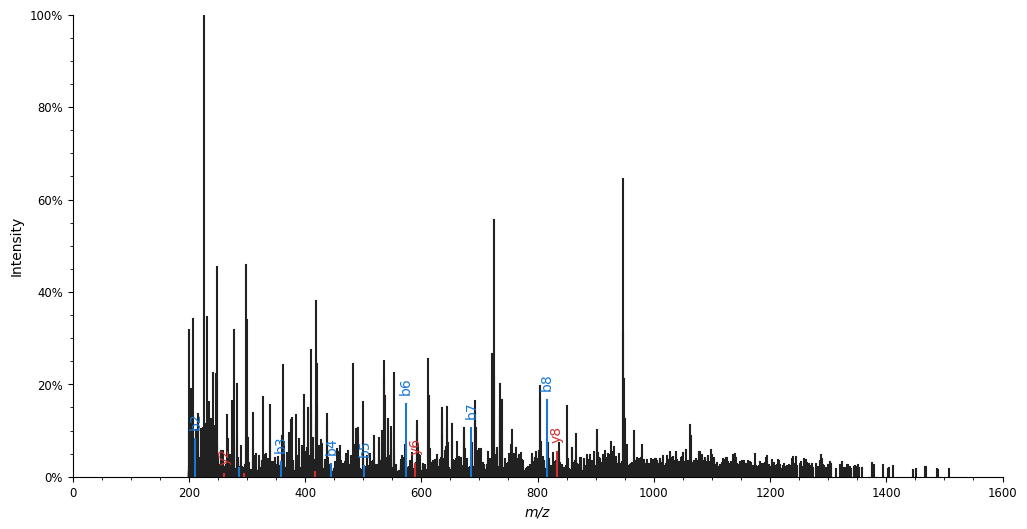

In [15]:
frags = plot_spectrum(spec_dict, peak_dict, psm_df, 0, flat_frag_df)

In [16]:
frags

,mz,intensity,type,loss_type,charge,number,position
0,114.091339,0.000000,98,0,1,1,0
1,833.440369,87557.734375,121,0,1,8,0
2,211.144104,133511.109375,98,0,1,2,1
3,736.387573,0.000000,121,0,1,7,1
4,358.212524,52217.914062,98,0,1,3,2
5,589.319153,44943.460938,121,0,1,6,2
6,445.244537,43516.750000,98,0,1,4,3
7,502.287140,0.000000,121,0,1,5,3
8,502.266022,35967.285156,98,0,1,5,4
9,445.265686,0.000000,121,0,1,4,4
